# Определение перспективного тарифа для телеком-компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов**

Тариф «Смарт»
Ежемесячная плата: 550 рублей
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.
Тариф «Ультра»
Ежемесячная плата: 1950 рублей
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.

**Примечание:**

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

## Изучение данных 

In [1]:
import pandas as pd # импортирую библиотеки, которые понадобятся для выполнения проекта
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt 
import seaborn as sns

Загрузим поочередно предоставленные базы, изучим их и определим имеющиеся в них недостатки.

Calls (информация о звонках)

In [2]:
ds_calls=pd.read_csv('/datasets/calls.csv')
display(ds_calls) # .head() не использую, чтобы увидеть и последние строки датасета
ds_calls.info()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


В столбце 'duration' имеются нулевые значения, определим их количество:

In [3]:
ds_calls['duration'][ds_calls['duration']==0].count()

39613

Проверим на наличие дубликатов:

In [4]:
ds_calls.duplicated().sum()

0

Таблица calls (информация о звонках):
- не имеет пропущенных значений
- не имеет дубликатов
- нулевые значения в столбце "duration" - это пропущенные звонки, их количество, относительно всего датасета, достаточно велико, оставим их без изменений
- столбец "call_date" имеет тип object, необходимо привести его к типу datetime
- из этого же столбца "call_date" извлечь значение месяцев в новый столбец "month" (потребуется для дальнейшего анализа и расчетов)
- поскольку "Мегалайн" округляет время до минут, а в столбце "duration" время указано в минутах, необходимо округлить значения до целого в большую сторону и изменить тип данных на int
- столбец "id" не несет необходимой информации, можно его удалить

Internet (информация об интернет-сессиях)

In [5]:
ds_internet = pd.read_csv('/datasets/internet.csv')
display(ds_internet)
ds_internet.info()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


В столбце 'mb_used' имеются нулевые значения, определим их количество:

In [6]:
ds_internet['mb_used'][ds_internet['mb_used']==0].count()

19598

Проверим на наличие дубликатов:

In [7]:
ds_internet.duplicated().sum()

0

Таблица Internet (информация об интернет-сессиях):
- не имеет пропущенных значений
- не имеет дубликатов
- нулевые значения в столбце "mb_used" - это несостоявшиеся сессии, их количество, относительно всего датасета, достаточно велико, оставим их без изменений
- столбец "session_date" имеет тип object, необходимо привести его к типу datetime
- из этого же столбца "session_date" извлечь значение месяцев в новый столбец "month" (потребуется для дальнейшего анализа и расчетов)
- поскольку "Мегалайн" веб-трафик отдельными сессиями не считает, то пока переводить Мб в Гб не требуется, достаточно округлить значения до целого в большую сторону и изменить тип данных на int
- столбцы "id" и "Unnamed: 0" не несут необходимой информации, можно их удалить

Messages (информация о сообщениях)

In [8]:
ds_messages = pd.read_csv('/datasets/messages.csv')
display(ds_messages)
ds_messages.info()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Проверим на наличие дубликатов:

In [9]:
ds_messages.duplicated().sum()

0

Таблица  Messages (информация о сообщениях):
- не имеет пропущенных значений
- не имеет дубликатов
- столбец "message_date" имеет тип object, необходимо привести его к типу datetime
- из этого же столбца "message_date" извлечь значение месяцев в новый столбец "month" (потребуется для дальнейшего анализа и расчетов)
- столбец "id" не несет необходимой информации, можно его удалить

Tariffs (информация о тарифах)

In [10]:
ds_tariffs = pd.read_csv('/datasets/tariffs.csv')
display(ds_tariffs)
ds_tariffs.info()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Таблица  Tariffs (информация о тарифах) предобработки данных не требует.

Users (информация о пользователях)

In [11]:
ds_users = pd.read_csv('/datasets/users.csv')
display(ds_users)
ds_users.info()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Проверим на наличие дубликатов:

In [12]:
ds_users.duplicated().sum()

0

Таблица  Users (информация о пользователях):
- пропущенные значения в столбце "churn_date" (462 значения) оставить без изменений, привести тип столбца к datetime
- из этого же столбца "churn_date" извлечь значение месяцев (где возможно) в новый столбец "сhurn_month" (потребуется для дальнейшего анализа и расчетов), заменить пропущенные значения на 0 и привести к типу int
- не имеет дубликатов
- столбец "reg_date" имеет тип object, необходимо привести его к типу datetime
- из этого же столбца "reg_date" извлечь значение месяцев в новый столбец "reg_month" (потребуется для дальнейшего анализа и расчетов)
- можно привести значения столбцов "city", "first_name", "last_name" к нижнему регистру и еще раз проверить на наличие дубликатов

## Предобработка данных

Согласно описанным выше недочетам проведем предобработку данных каждой из таблиц поочередно.

Calls (информация о звонках)

In [13]:
ds_calls['call_date'] = pd.to_datetime(ds_calls['call_date'], format='%Y-%m-%d') # приводим значения столбца к типу datetime
ds_calls['month'] = ds_calls['call_date'].dt.month  # создаем столбец с указанием месяца звонка
ds_calls['duration'] = np.ceil(ds_calls['duration']).astype('int') # приводим значения столбца к типу int, c округлением в большую сторону
ds_calls = ds_calls.drop(['id'], axis=1) # удаляем ненужный столбец "id"
ds_calls.head()

,call_date,duration,user_id,month
0,2018-07-25,0,1000,7
1,2018-08-17,0,1000,8
2,2018-06-11,3,1000,6
3,2018-09-21,14,1000,9
4,2018-12-15,6,1000,12


Internet (информация об интернет-сессиях)

In [14]:
ds_internet['session_date'] = pd.to_datetime(ds_internet['session_date'], format='%Y-%m-%d') # приводим значения столбца к типу datetime
ds_internet['month'] = ds_internet['session_date'].dt.month  # создаем столбец с указанием месяца веб-сессии
ds_internet['mb_used'] = np.ceil(ds_internet['mb_used']).astype('int') # приводим значения столбца к типу int, c округлением в большую сторону
ds_internet = ds_internet.drop(['id', 'Unnamed: 0'], axis=1) # удаляем ненужные столбцы "id" и "Unnamed: 0"
ds_internet.head()

,mb_used,session_date,user_id,month
0,113,2018-11-25,1000,11
1,1053,2018-09-07,1000,9
2,1198,2018-06-25,1000,6
3,551,2018-08-22,1000,8
4,303,2018-09-24,1000,9


Messages (информация о сообщениях)

In [15]:
ds_messages['message_date'] = pd.to_datetime(ds_messages['message_date'], format='%Y-%m-%d') # приводим значения столбца к типу datetime
ds_messages['month'] = ds_messages['message_date'].dt.month  # создаем столбец с указанием месяца веб-сессии
ds_messages = ds_messages.drop(['id'], axis=1) # удаляем ненужный столбец "id"
ds_messages.head()

,message_date,user_id,month
0,2018-06-27,1000,6
1,2018-10-08,1000,10
2,2018-08-04,1000,8
3,2018-06-16,1000,6
4,2018-12-05,1000,12


Users (информация о пользователях)

In [16]:
ds_users['churn_date'] = pd.to_datetime(ds_users['churn_date'], format='%Y-%m-%d') # приводим значения столбца к типу datetime
ds_users['churn_month'] = ds_users['churn_date'].dt.month  # создаем столбец с указанием месяца прекращения пользования тарифом
ds_users['churn_month'] = ds_users['churn_month'].fillna(0).astype('int') # заменяем NaN на 0 и приводим значения к типу int

ds_users['reg_date'] = pd.to_datetime(ds_users['reg_date'], format='%Y-%m-%d') # приводим значения столбца к типу datetime
ds_users['reg_month'] = ds_users['reg_date'].dt.month  # создаем столбец с указанием месяца подключения тарифа

for column in ['city', 'first_name', 'last_name']: # через цикл приводим значения указанных выше столбцов к нижнему регистру
    ds_users[column] = ds_users[column].str.lower()
display("Количество дубликатов:", ds_users.duplicated().sum()) # проверяем на наличие дубликатов

for column in ['city', 'first_name', 'last_name']: # дубликатов не нашлось, а названия городов, имена и фамилии правильнее указывать с заглавной буквы
    ds_users[column] = ds_users[column].str.capitalize()

ds_users

'Количество дубликатов:'

0

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,churn_month,reg_month
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0,5
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,0,11
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,0,6
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,0,8
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,0,5
...,...,...,...,...,...,...,...,...,...,...
495,1495,65,NaT,Иркутск,Авксентий,Фокин,2018-08-28,ultra,0,8
496,1496,36,NaT,Вологда,Трифон,Блохин,2018-01-27,smart,0,1
497,1497,32,NaT,Челябинск,Каролина,Агеева,2018-10-09,smart,0,10
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,10,7


**Расчеты для каждого пользователя**

Для расчетов по каждому пользователю по месяцам создадим сводные таблицы
1. Количество сделанных звонков и израсходованных минут разговора по месяцам

In [17]:
calls_in_month = ds_calls.pivot_table(     # создаем сводную таблилцу
    index=['user_id', 'month'],
    values='duration',
    aggfunc=['count', 'sum']
)
calls_in_month.columns = ['calls_count', 'calls_duration'] # для удобства переименуем столбцы сводной таблицы
calls_in_month

calls_count  calls_duration
user_id month                             
1000    5               22             159
        6               43             172
        7               47             340
        8               52             408
        9               58             466
...                    ...             ...
1498    10              41             247
1499    9                9              70
        10              68             449
        11              74             612
        12              69             492

[3174 rows x 2 columns]

2. Количество отправленных сообщений по месяцам

In [18]:
messages_in_month = ds_messages.pivot_table(
    index=['user_id', 'month'],
    values='user_id',
    aggfunc='count'
)
messages_in_month.columns = ['messages_count']
messages_in_month

messages_count
user_id month                
1000    5                  22
        6                  60
        7                  75
        8                  81
        9                  57
...                       ...
1498    10                 42
1499    9                  11
        10                 48
        11                 59
        12                 66

[2717 rows x 1 columns]

3. Объем израсходованного интернет-трафика по месяцам

In [19]:
internet_in_month = ds_internet.pivot_table(
    index=['user_id', 'month'],
    values='mb_used',
    aggfunc='sum'
)
internet_in_month

mb_used
user_id month         
1000    5         2256
        6        23257
        7        14016
        8        14070
        9        14581
...                ...
1498    10       20604
1499    9         1848
        10       17809
        11       17984
        12       13077

[3203 rows x 1 columns]

4. Помесячная выручка с каждого пользователя

Создадим новый датасет, поочередно объеденив полученные сводные таблицы плюс столбец с указанием тарифа из таблицы ds_users

In [20]:
ds_joined = calls_in_month.merge(messages_in_month,  on=['user_id', 'month'], how='outer')
ds_joined = ds_joined.merge(internet_in_month,  on=['user_id', 'month'], how='outer')
ds_joined = ds_joined.reset_index(drop=False)
ds_joined = ds_joined.merge(ds_users[['user_id', 'tariff']], on='user_id', how='left')
ds_joined

,user_id,month,calls_count,calls_duration,messages_count,mb_used,tariff
0,1000,5,22.0,159.0,22.0,2256.0,ultra
1,1000,6,43.0,172.0,60.0,23257.0,ultra
2,1000,7,47.0,340.0,75.0,14016.0,ultra
3,1000,8,52.0,408.0,81.0,14070.0,ultra
4,1000,9,58.0,466.0,57.0,14581.0,ultra
...,...,...,...,...,...,...,...
3209,1489,9,NaN,NaN,32.0,17232.0,smart
3210,1489,10,NaN,NaN,21.0,19588.0,smart
3211,1489,11,NaN,NaN,20.0,17516.0,smart
3212,1489,12,NaN,NaN,35.0,17341.0,smart


Отсутствующие значения заменим на 0

In [21]:
ds_joined = ds_joined.fillna(0)
ds_joined.info()
ds_joined

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         3214 non-null   int64  
 1   month           3214 non-null   int64  
 2   calls_count     3214 non-null   float64
 3   calls_duration  3214 non-null   float64
 4   messages_count  3214 non-null   float64
 5   mb_used         3214 non-null   float64
 6   tariff          3214 non-null   object 
dtypes: float64(4), int64(2), object(1)
memory usage: 200.9+ KB


,user_id,month,calls_count,calls_duration,messages_count,mb_used,tariff
0,1000,5,22.0,159.0,22.0,2256.0,ultra
1,1000,6,43.0,172.0,60.0,23257.0,ultra
2,1000,7,47.0,340.0,75.0,14016.0,ultra
3,1000,8,52.0,408.0,81.0,14070.0,ultra
4,1000,9,58.0,466.0,57.0,14581.0,ultra
...,...,...,...,...,...,...,...
3209,1489,9,0.0,0.0,32.0,17232.0,smart
3210,1489,10,0.0,0.0,21.0,19588.0,smart
3211,1489,11,0.0,0.0,20.0,17516.0,smart
3212,1489,12,0.0,0.0,35.0,17341.0,smart


Далее необходимо вычесть бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножить на значение из тарифного плана; прибавить абонентскую плату, соответствующую тарифному плану

Создадим собственную функцию для подсчета указанных значений:

In [22]:
def revenue_calc(row):
    calls_duration = row['calls_duration']
    messages_count = row['messages_count']
    mb_used = row['mb_used']
    tariff = row['tariff']
    
    if tariff == 'smart':
        i=0
    else:
        i=1
    
    more_calls_duration = calls_duration - ds_tariffs.loc[i, 'minutes_included']
    more_mb_used = mb_used - ds_tariffs.loc[i, 'mb_per_month_included']
    more_messages_count = messages_count - ds_tariffs.loc[i, 'messages_included']
        
    if more_calls_duration < 0:
        more_calls_duration = 0
    if more_mb_used < 0:
        more_mb_used = 0
    if more_messages_count < 0:
        more_messages_count = 0
        
    return (ds_tariffs.loc[i, 'rub_per_message'] * more_messages_count + 
                ds_tariffs.loc[i, 'rub_per_gb'] * ((more_mb_used - 1)//1024 + 1) + 
                ds_tariffs.loc[i, 'rub_per_minute'] * more_calls_duration + 
                ds_tariffs.loc[i, 'rub_monthly_fee']
                ) 

Используя собственную функцию посчитаем помесячную выручку с каждого пользователя, полученные данные сохраним в новый столбец "revenue"

In [23]:
ds_joined['revenue'] = ds_joined.apply(revenue_calc, axis=1)
ds_joined

,user_id,month,calls_count,calls_duration,messages_count,mb_used,tariff,revenue
0,1000,5,22.0,159.0,22.0,2256.0,ultra,1950.0
1,1000,6,43.0,172.0,60.0,23257.0,ultra,1950.0
2,1000,7,47.0,340.0,75.0,14016.0,ultra,1950.0
3,1000,8,52.0,408.0,81.0,14070.0,ultra,1950.0
4,1000,9,58.0,466.0,57.0,14581.0,ultra,1950.0
...,...,...,...,...,...,...,...,...
3209,1489,9,0.0,0.0,32.0,17232.0,smart,950.0
3210,1489,10,0.0,0.0,21.0,19588.0,smart,1550.0
3211,1489,11,0.0,0.0,20.0,17516.0,smart,1150.0
3212,1489,12,0.0,0.0,35.0,17341.0,smart,950.0


Прежде чем перейти к анализу полученных данных, поскольку все значения в таблице целочисленные, для удобства работы приведем их к типу "int".

In [24]:
ds_joined[['calls_count', 'calls_duration', 'messages_count', 'mb_used', 'revenue']] = ds_joined[['calls_count', 'calls_duration', 'messages_count', 'mb_used', 'revenue']].astype('int')
ds_joined.head()

,user_id,month,calls_count,calls_duration,messages_count,mb_used,tariff,revenue
0,1000,5,22,159,22,2256,ultra,1950
1,1000,6,43,172,60,23257,ultra,1950
2,1000,7,47,340,75,14016,ultra,1950
3,1000,8,52,408,81,14070,ultra,1950
4,1000,9,58,466,57,14581,ultra,1950


## Анализ данных

Для ответа на вопрос: "Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?" создадим сводную таблицу по всей выборке:

In [25]:
average_per_month = ds_joined.pivot_table(
    index=['tariff', 'month'],
    values=['calls_duration', 'messages_count', 'mb_used'], 
    aggfunc='median'
).astype('int')
average_per_month

calls_duration  mb_used  messages_count
tariff month                                         
smart  1                 162     7107              15
       2                 258    12572              20
       3                 409    15690              23
       4                 368    14104              28
       5                 433    16343              30
       6                 400    16095              28
       7                 414    15948              29
       8                 432    16855              27
       9                 435    16050              30
       10                427    17248              30
       11                428    17036              28
       12                471    17741              29
ultra  1                 382    14808              32
       2                 168     7335               5
       3                 403    17513              20
       4                 453    16662              17
       5                 519    18717              25
       6                 479    19495              27
       7                 542    20034              38
       8                 500    18945              40
       9                 520    19675              43
       10                533    20359              49
       11                546    18398              43
       12                584    21994              51

In [26]:
ds_users['tariff'].value_counts() #посчитаем колличество пользователей каждого тарифа

smart    351
ultra    149
Name: tariff, dtype: int64

Среднее значение, дисперсию и стандартное отклонение можно также увидеть, построив сводную таблицу по тарифам:

In [27]:
average_per_tariff = ds_joined.pivot_table(
    index=['tariff'],
    values=['calls_duration', 'messages_count', 'mb_used'], 
    aggfunc=[np.mean, np.var, np.std]
).astype('int')
average_per_tariff

mean                                   var             \
       calls_duration mb_used messages_count calls_duration    mb_used   
tariff                                                                   
smart             417   16229             33          36219   34545911   
ultra             526   19486             49         100873  101935621   

                                 std                         
       messages_count calls_duration mb_used messages_count  
tariff                                                       
smart             796            190    5877             28  
ultra            2285            317   10096             47

Для наглядности полученных результатов построим графики диаграммы размаха:

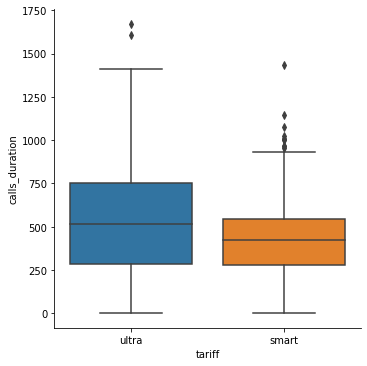

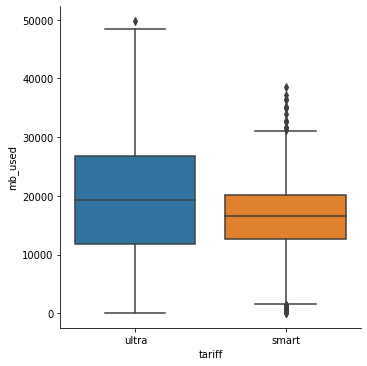

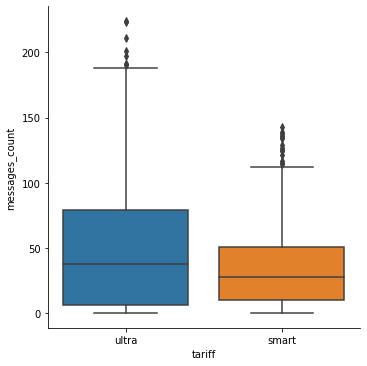

In [28]:
for column in ['calls_duration', 'mb_used', 'messages_count']:    
    sns.catplot(x='tariff', y=column, kind='box', data=ds_joined, orient='v')

Очевидно, что для оператора тариф "Ультра" является более выгодным. Во всех трех случаях, дисперсия в тарифе "Ультра" выше, медианные значения смещены в большую сторону.

Построим гистограммы по каждому из трех показателей (звонки, интернет и сообщения):

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Гистограмма звонков')

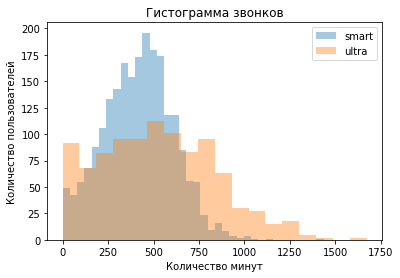

In [29]:
smart = ds_joined.query("tariff == 'smart'")
ultra = ds_joined.query("tariff == 'ultra'")
sns.distplot(smart['calls_duration'], kde=False)
sns.distplot(ultra['calls_duration'], kde=False)
plt.legend(['smart', 'ultra'])
plt.xlabel('Количество минут')
plt.ylabel('Количество пользователей')
plt.title('Гистограмма звонков')

Text(0.5, 1.0, 'Гистограмма веб-трафика')

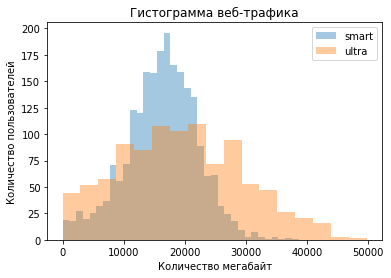

In [30]:
sns.distplot(smart['mb_used'], kde=False)
sns.distplot(ultra['mb_used'], kde=False)
plt.legend(['smart', 'ultra'])
plt.xlabel('Количество мегабайт')
plt.ylabel('Количество пользователей')
plt.title('Гистограмма веб-трафика')

Text(0.5, 1.0, 'Гистограмма сообщений')

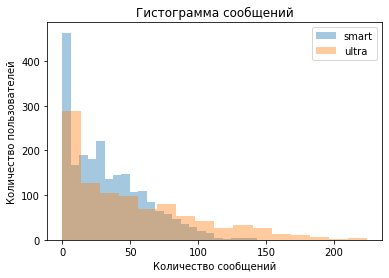

In [31]:
sns.distplot(smart['messages_count'], kde=False)
sns.distplot(ultra['messages_count'], kde=False)
plt.legend(['smart', 'ultra'])
plt.xlabel('Количество сообщений')
plt.ylabel('Количество пользователей')
plt.title('Гистограмма сообщений')

**ВЫВОД:**
Дисперсия тарифа "Ультра" выше, чем у тарифа "Смарт", распределение в тарифах "Смарт" сильнее скошено влево, чем в тарифах "Ультра". За пределы включенных в тариф минут, Мб и сообщений чаще всего выходят пользователи тарифа "Смарт". Для оператора однозначно выгоднее тариф "Ультра". 

## Проверка гипотез

- Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Формулируем нулевую и альтернативную гипотезы. Поскольку в нулевой гипотезе должен быть знак равенства, сформулируем их таким образом:

Н0 - Средние выручки пользователей тарифов "Ультра" и "Смарт" равны

Н1 - Средние выручки пользователей тарифов "Ультра" и "Смарт" различаются

Пороговое значение alpha примем равное 0,05, для нашей выборки такое значение будет достаточным для подтверждения или опровержения гипотез

In [32]:
alpha = 0.05 
results = st.ttest_ind(
    smart['revenue'], 
    ultra['revenue'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.9776448000521676e-158
Отвергаем нулевую гипотезу


P-значение в нашем эксперименте значительно меньше alpha, даже если принять alpha равную 0,01, значит можно смело отвергнуть нулевую гипотезу. Средние выручки пользователей тарифов "Ультра" и "Смарт" действительно различаются.

- Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Формулируем нулевую и альтернативную гипотезы подобным образом:

Н0 - Средняя выручка пользователей из Москвы и средняя выручка пользователей из других регионов равны

Н1 - Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Пороговое значение alpha примем равное 0,05

In [33]:
ds_joined = ds_joined.merge(ds_users[['user_id', 'city',]], on='user_id', how='left') # добавим к нашей выборке данные о городах
moscow = ds_joined.query('city == "Москва"')['revenue'] # выберем пользователей из Москвы 
regions = ds_joined.query('city != "Москва"')['revenue'] # и из регионов

alpha = 0.05 
results = st.ttest_ind(moscow, regions)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.531666503831252
Не получилось отвергнуть нулевую гипотезу


В данном случае, даже при критическом уровне статистической значимости в 5% отвергнуть нулевую гипотезу нельзя, слишком высока вероятность. Поэтому можно сделать вывод, что средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

## Общий вывод

Полученные для анализа данные нуждались в предобработке, нами было проделано:
- изменили тип данных там, где это было возможно и необходимо для комфортной работы
- из столбца с данными о дате определили и сохранили в новый столбец значения месяцев 
- избавились от ненужных столбцов
- при помощи сводных таблиц подсчитали звонки, веб-трафик и сообщения, использованные пользователями по месяцам
- объединили несколько таблиц в одну для дальнейшей работы 
- подсчитали выручку оператора по каждому пользователю каждого тарифа в месяц

В результате проведенного анализа было определено:
- пользователи тарифа "Ультра" чаще укладываются в предоставленные им смс, минуты и Мб по тарифу.
- пользователей тарифа "Смарт" почти в 2 раза больше, чем тарифа "Ультра"
- средние выручки по тарифам "Смарт" и "Ультра" различаются
- средняя выручка пользователей из Москвы не отличается от выручки пользователей других регионов

Исходя из вышеперечисленного можно сделать следующий вывод - для оператора однозначно выгоднее продвигать тариф "Ультра".
